In [12]:
import pandas as pd
import os
import numpy as np
import torch
import argparse

import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm

from analysis import screen_routine
from dataset import SequenceDataset
from utils import hamming_distance

In [13]:
# FUNCTIONS

def select_2Cys(library, pred_list):
    """Filter library to only include those with 2 Cys (also remove problematic residues, KR"""
    seqs = [''.join(l) for l in library]
    # seq_filter = [(s[4:].count('C') == 2 and s.count('K') < 1 and s.count('R') < 1) for s in seqs]
    seq_filter = [(s[4:].count('C') == 2) for s in seqs]

    plist, slist = [], []
    for s, f, p in zip(seqs, seq_filter, pred_list):
        if f:
            slist.append(s)
            plist.append(p)
    
    # filter out any with K or R included
    print('%s seqs passed flagged residue filters' % str(len(slist)))
    library = slist
    pred_list = plist
    return library, pred_list

def hamming(args, library, pred_list):
    """Filter library based on hamming cutoff"""
    if args.hamming > 0:
        ref = SequenceDataset(sele=args.sele, anti=args.anti, features=args.features, variable_region=args.variable_region)
        tr_peps = ref.df.var_seq.values.astype('str')
        tr_peps = np.array([list(word) for word in tr_peps])
        flag, min_H, closest = [], [], []
        library = np.array([list(word) for word in library])
        for pep in tqdm(library):
            distances = hamming_distance(P=tr_peps, pep=pep, return_distance=True)
            min_dist = np.min(distances)
            flag.append(min_dist > args.hamming)
            min_H.append(min_dist)
            sim_seq = tr_peps[np.argmin(distances), :]
            closest.append(sim_seq)
        
        # library = np.array([list(word) for word in library])
        library = library[flag, :]
        pred_list = torch.tensor(pred_list).detach().numpy()[flag]
        min_H = np.array(min_H)[flag]
        closest = np.array(closest)[flag]
    
        library = np.array([''.join(l) for l in library])
        closest = np.array([''.join(l) for l in closest])
        df = pd.DataFrame({
            'SEQ': library, 
            'MODEL_SCORE': pred_list, 
            'MIN_HAMMING_DIST': min_H, 
            'MOST_SIMILAR_TRAINING_SEQ': closest
        })
    
        print('%s peptides passed Hamming cutoff' % str(df.shape[0]))
        return df, ref
    else:
        ref = SequenceDataset(sele=args.sele, anti=args.anti, features=args.features, variable_region=args.variable_region)
        return ref

def y_star_score(sel_df, anti_df):
    """Calculate Y-star scores for a sele/anti dataset"""
    
    def y_star_single(sel_df, anti_df, p, aa):
        alphabet = 'ACDEFGHIKLMNPQRSTVWY'
        f_sel = sel_df.loc[sel_df['var_seq'].str[p] == alphabet[aa]]['count'].sum() / sel_df['count'].sum()
        f_anti = anti_df.loc[anti_df['var_seq'].str[p] == alphabet[aa]]['count'].sum() / anti_df['count'].sum()
        return float(f_sel) / float(f_anti)

    seqs = sel_df['var_seq'].values
    pos_idx = len(seqs[0])
    aa_idx = 20
    y_star = np.zeros((pos_idx, aa_idx), dtype=np.float32)
    for p in tqdm(range(pos_idx)):
        for aa in range(aa_idx):
            y_star[p, aa] = y_star_single(sel_df, anti_df, p, aa)
    return y_star

def s_score(df, y_star):
    """Calculate S Score for a df of seqs"""
    alphabet = 'ACDEFGHIKLMNPQRSTVWY'
    y_star = np.log2(y_star)
    seqs = df['var_seq']
    s_scores = []
    for s in tqdm(seqs):
        y_list = []
        flag = True
        for idx, aa in enumerate(s):
            try:
                y = y_star[idx, alphabet.index(aa)]
                y_list.append(y)
            except ValueError:
                flag = False
                break
        if flag:
            s_scores.append(np.sum(y_list))
    return s_scores


In [ ]:
# CONFIG - Peptide set 1 (2Cys)

config = {
    'features': 'onehot', 
    'model': 'MLP', 
    'learning_rate': 0.01, 
    'routine': 'screen', 
    'ckpt': 'checkpoints/NNK7_rd3_epoch=33_val_accuracy=0.92.ckpt', 
    'variable_region': [14, 15, 16, 17, 18, 19, 20, 21], 
    'variable_length': 8, 
    'filter_seq': None, 
    'hamming': 2, 
    'thresh': 0.97, 
    'sele': '/proj/kuhl_lab/users/dieckhau/LynD-substrate-modeling/LynD-substrate-modeling/data/csv/NNK7/rd3/sele', 
    'anti': '/proj/kuhl_lab/users/dieckhau/LynD-substrate-modeling/LynD-substrate-modeling/data/csv/NNK7/rd3/anti', 
    'seed': 1234, 
    'include_C': True, 
    'activity': 'high'
}

args = argparse.Namespace(**config)

def nominate_2Cys(args):
    """Full nomination routine for Peptide Set 1 (2xCys) """

    # screen 1M random peptides (takes ~10 sec plus ~10 min for Hamming filter)
    library, pred_list = screen_routine(args, N=1000000, thresh=args.thresh, H=args.hamming, save=False, length=args.variable_length, filter=args.filter_seq)
    
    # SELECTION CRITERIA: select those with 2x Cys in positions 5-8
    library, pred_list = select_2Cys(library, pred_list)
    # p = torch.tensor(pred_list).detach().cpu().numpy()
    # print(p)
    # print(np.mean(p))
    # print(np.sum(p > 0.5) / p.size)
    # return
    # filter by Hamming cutoff (may take a few minutes)
    df, ref = hamming(args, library, pred_list)
    
    # Calculate S scores for rd3 sequences and add them to dataframe
    ref_df = ref.df
    sel_df = ref_df.loc[ref_df['active'] == 1]
    anti_df = ref_df.loc[ref_df['active'] == 0]
    
    y_star = y_star_score(sel_df, anti_df)
    sel_s = s_score(sel_df, y_star)
    anti_s = s_score(anti_df, y_star)
    
    df['var_seq'] = df.SEQ
    pep_s = s_score(df, y_star)
    
    # show sel/anti s scores compared to nominated peptides
    
    disp = pd.concat([
        pd.DataFrame({'Dataset': 'Selection', 'S Score': sel_s}), 
        pd.DataFrame({'Dataset': 'Antiselection', 'S Score': anti_s}),
        pd.DataFrame({'Dataset': 'Nomination', 'S Score': pep_s})
                      
    ])
    disp = disp.reset_index(drop=True)
    
    ax = sns.kdeplot(data=disp, x='S Score', hue='Dataset', common_norm=False, fill=True)
    sns.move_legend(ax, 'upper left')
    
    # convert S Scores to percentiles for better interpretability (0 to 1)
    s_total = np.concatenate([sel_s, anti_s])
    pep_s_perc = [(p > s_total).sum() / s_total.size for p in pep_s]
    
    # save df to output
    df['S_SCORE'] = pep_s
    df['S_SCORE_PERCENTILE'] = pep_s_perc
    df.to_csv('NNK7_NOMINATION_2Cys.csv')

nominate_2Cys(args)

In [6]:
def select_C6(library, pred_list):
    """Filter library to only include those with one C"""
    seqs = [''.join(l) for l in library]

    # allowed_4 = 'AFILMPSTVY'
    # allowed_6 = 'AFILMSTVY'
    seq_filter = [(s.count('C') == 1 and s[5] == 'C') for s in seqs]
    # seq_filter = [(s[5] == 'C' and s.count('C') == 1 and s[4] in allowed_4 and s[6] in allowed_6) for s in seqs]
    plist, slist = [], []
    for s, f, p in zip(seqs, seq_filter, pred_list):
        if f:
            slist.append(s)
            plist.append(p)
    
    # filter out any with K or R included
    print('%s seqs passed flagged residue filters' % str(len(slist)))
    library = slist
    pred_list = plist
    return library, pred_list

In [7]:
# CONFIG - Peptide set 2A (6Walk)

config = {
    'features': 'onehot', 
    'model': 'MLP', 
    'learning_rate': 0.01, 
    'routine': 'screen', 
    'ckpt': 'checkpoints/NNK7_rd3_epoch=33_val_accuracy=0.92.ckpt', 
    'variable_region': [14, 15, 16, 17, 18, 19, 20, 21], 
    'variable_length': 8, 
    'filter_seq': None, 
    'hamming': 2, 
    'thresh': 0.97, 
    'sele': '/proj/kuhl_lab/users/dieckhau/LynD-substrate-modeling/LynD-substrate-modeling/data/csv/NNK7/rd3/sele', 
    'anti': '/proj/kuhl_lab/users/dieckhau/LynD-substrate-modeling/LynD-substrate-modeling/data/csv/NNK7/rd3/anti', 
    'seed': 1234, 
    'include_C': True, 
    'activity': 'high'
}

args = argparse.Namespace(**config)

def nominate_6Walk(args):

    # generate 1M peptides with high predicted activity
    library, pred_list = screen_routine(args, N=1000000, thresh=args.thresh, H=args.hamming, save=False, length=args.variable_length, filter=args.filter_seq)
    
    # SELECTION CRITERIA: 1x Cys and only in position 6
    library, pred_list = select_C6(library, pred_list)
    
    # p = torch.tensor(pred_list).detach().cpu().numpy()
    # print(p)
    # print(np.mean(p))
    # print(np.sum(p > 0.5) / p.size)
    # return
   
    # hamming screen
    df, ref = hamming(args, library, pred_list)

    # S-score calculation
    ref_df = ref.df
    sel_df = ref_df.loc[ref_df['active'] == 1]
    anti_df = ref_df.loc[ref_df['active'] == 0]
    
    y_star = y_star_score(sel_df, anti_df)
    sel_s = s_score(sel_df, y_star)
    anti_s = s_score(anti_df, y_star)
    
    df['var_seq'] = df.SEQ
    pep_s = s_score(df, y_star)

    # visualize S scores
    disp = pd.concat([
        pd.DataFrame({'Dataset': 'Selection', 'S Score': sel_s}), 
        pd.DataFrame({'Dataset': 'Antiselection', 'S Score': anti_s}),
        pd.DataFrame({'Dataset': 'Nomination', 'S Score': pep_s})
                      
    ])
    disp = disp.reset_index(drop=True)
    
    ax = sns.kdeplot(data=disp, x='S Score', hue='Dataset', common_norm=False, fill=True)
    sns.move_legend(ax, 'upper left')
    
    # convert S Scores to percentiles for better interpretability (0 to 1)
    s_total = np.concatenate([sel_s, anti_s])
    pep_s_perc = [(p > s_total).sum() / s_total.size for p in pep_s]
    
    # save df to output
    df['S_SCORE'] = pep_s
    df['S_SCORE_PERCENTILE'] = pep_s_perc
    df.to_csv('NNK7_NOMINATION_C6Walk.csv')
    
    return df

df = nominate_6Walk(args)


Dropout: 	 0.1
Model:
 MLP(
  (W_in): Linear(in_features=160, out_features=128, bias=True)
  (drop): Dropout(p=0.1, inplace=False)
  (W_inter): ModuleList(
    (0): Linear(in_features=128, out_features=128, bias=True)
  )
  (W_out): Linear(in_features=128, out_features=1, bias=True)
  (sig): Sigmoid()
) 


100%|███████████████████████████████████████████████████████████████████████| 977/977 [00:04<00:00, 209.50it/s]


87639 seqs passed flagged residue filters
[0.5804953  0.01563589 0.90843844 ... 0.79278517 0.41738912 0.97019815]
0.6964582
0.7251109665788062


In [ ]:
# CONFIG - Peptide set 2B (6Walk_manual)

config = {
    'features': 'onehot', 
    'model': 'MLP', 
    'learning_rate': 0.01, 
    'routine': 'screen', 
    'ckpt': 'checkpoints/NNK7_rd3_epoch=33_val_accuracy=0.92.ckpt', 
    'variable_region': [14, 15, 16, 17, 18, 19, 20, 21], 
    'variable_length': 8, 
    'filter_seq': None, 
    'hamming': -1, 
    'thresh': 0.97, 
    'sele': '/proj/kuhl_lab/users/dieckhau/LynD-substrate-modeling/LynD-substrate-modeling/data/csv/NNK7/rd3/sele', 
    'anti': '/proj/kuhl_lab/users/dieckhau/LynD-substrate-modeling/LynD-substrate-modeling/data/csv/NNK7/rd3/anti', 
    'seed': 1234, 
    'include_C': True, 
    'activity': 'high'
}

args = argparse.Namespace(**config)

from trainer import SequenceModelPL
from dataset import LibraryDataset
from torch.utils.data import DataLoader

def nominate_6Walk_manual(args):

    # make custom peptide set

    # retrieve model and run predictions
    model = SequenceModelPL.load_from_checkpoint(args.ckpt, args=args).model
    model = model.to('cuda')
    model.eval()

    minus1 = 'AFILMPV'
    plus1 = 'AFILMVY'
    linkers = 'GA'

    lib = []
    tags = []
    for m in minus1:
        for p in plus1:
            for l in linkers:
                for n in range(6):
                    lib.append(l * n + m + 'C' + p + l * (6 - n - 1))
                    tags.append(m + 'C' + p + '_poly' + l + '_C' + str(n + 2))
    library = lib
    print(lib)
    library = [list(word) for word in library]
    library = np.array(library)

    pred_list = []
    # screen custom dataset    
    ds = LibraryDataset(library, features=args.features)
    loader = DataLoader(ds, num_workers=8, shuffle=False, batch_size=1024)
    for batch in tqdm(loader):
        batch = batch.to('cuda') 
        preds = model(batch)
        preds = torch.squeeze(preds, -1)
        pred_list.append(preds) 
    pred_list = torch.cat(pred_list, dim=0).to('cpu').detach().numpy()
    print(pred_list)

    library = [''.join(li) for li in library]
    
    df = pd.DataFrame({
        'SEQ': library, 
        'MODEL_SCORE': pred_list
    })
    
    # S-score calculation
    ref = hamming(args, library, pred_list)
    ref_df = ref.df
    sel_df = ref_df.loc[ref_df['active'] == 1]
    anti_df = ref_df.loc[ref_df['active'] == 0]
    
    y_star = y_star_score(sel_df, anti_df)
    sel_s = s_score(sel_df, y_star)
    anti_s = s_score(anti_df, y_star)
    
    df['var_seq'] = df.SEQ
    pep_s = s_score(df, y_star)

    # visualize S scores
    disp = pd.concat([
        pd.DataFrame({'Dataset': 'Selection', 'S Score': sel_s}), 
        pd.DataFrame({'Dataset': 'Antiselection', 'S Score': anti_s}),
        pd.DataFrame({'Dataset': 'Nomination', 'S Score': pep_s})
                      
    ])
    disp = disp.reset_index(drop=True)
    
    ax = sns.kdeplot(data=disp, x='S Score', hue='Dataset', common_norm=False, fill=True)
    sns.move_legend(ax, 'upper left')
    
    # convert S Scores to percentiles for better interpretability (0 to 1)
    s_total = np.concatenate([sel_s, anti_s])
    pep_s_perc = [(p > s_total).sum() / s_total.size for p in pep_s]
    
    # save df to output
    df['S_SCORE'] = pep_s
    df['S_SCORE_PERCENTILE'] = pep_s_perc
    df['TAG'] = tags
    df.to_csv('NNK7_C6Walk_Manual.csv')
    
    return df

df = nominate_6Walk_manual(args)


In [8]:
def select_C6_only(library, pred_list):
    """Filter library to only include those with 1 Cys in position 6"""
    seqs = [''.join(l) for l in library]

    seq_filter = [(s[5] == 'C' and s.count('C') == 1) for s in seqs]
    plist, slist = [], []
    for s, f, p in zip(seqs, seq_filter, pred_list):
        if f:
            slist.append(s)
            plist.append(p)
    
    print('%s seqs passed flagged residue filters' % str(len(slist)))
    library = slist
    pred_list = plist
    return library, pred_list

Dropout: 	 0.1
Model:
 MLP(
  (W_in): Linear(in_features=160, out_features=128, bias=True)
  (drop): Dropout(p=0.1, inplace=False)
  (W_inter): ModuleList(
    (0): Linear(in_features=128, out_features=128, bias=True)
  )
  (W_out): Linear(in_features=128, out_features=1, bias=True)
  (sig): Sigmoid()
) 
Library filtered according to C6 down to 169067 sequences
[['T' 'A' 'D' 'P' 'Y' 'C' 'C' 'A']
 ['G' 'Y' 'Q' 'D' 'P' 'C' 'D' 'L']
 ['N' 'R' 'D' 'F' 'E' 'C' 'F' 'Q']
 ['G' 'C' 'R' 'E' 'Q' 'C' 'V' 'E']
 ['Q' 'H' 'P' 'C' 'Y' 'C' 'M' 'N']]


100%|████████████████████████████████████████████████████████████████████████| 166/166 [00:01<00:00, 83.06it/s]


46570 peptides passed predicted activity threshold
4938 seqs passed flagged residue filters
Curated dataset sizes:
Selection:	 469680 
Antiselection:	 491765


100%|██████████████████████████████████████████████████████████████████████| 4938/4938 [06:59<00:00, 11.78it/s]


3340 peptides passed Hamming cutoff


100%|██████████████████████████████████████████████████████████████████| 3340/3340 [00:00<00:00, 114790.03it/s]


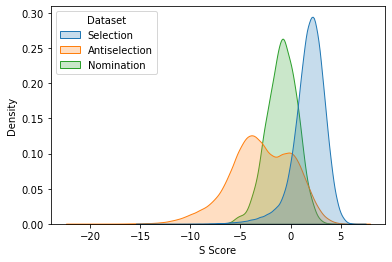

In [11]:
# CONFIG - Peptide set 3 (C6Range)

config = {
    'features': 'onehot', 
    'model': 'MLP', 
    'learning_rate': 0.01, 
    'routine': 'screen', 
    'ckpt': 'checkpoints/NNK7_rd3_epoch=33_val_accuracy=0.92.ckpt', 
    'variable_region': [14, 15, 16, 17, 18, 19, 20, 21], 
    'variable_length': 8, 
    'filter_seq': 'C6', 
    'hamming': 2, 
    'thresh': 0.03, 
    'sele': '/proj/kuhl_lab/users/dieckhau/LynD-substrate-modeling/LynD-substrate-modeling/data/csv/NNK7/rd3/sele', 
    'anti': '/proj/kuhl_lab/users/dieckhau/LynD-substrate-modeling/LynD-substrate-modeling/data/csv/NNK7/rd3/anti', 
    'seed': 1234, 
    'include_C': True, 
    'activity': 'low'
}

args = argparse.Namespace(**config)

from trainer import SequenceModelPL
from dataset import LibraryDataset
from torch.utils.data import DataLoader

def nominate_C6Range(args):

    # generate 1M peptides with high predicted activity
    library, pred_list = screen_routine(args, N=1000000, thresh=args.thresh, H=args.hamming, save=False, length=args.variable_length, filter=args.filter_seq)    

    library, pred_list = select_C6_only(library, pred_list)

    # keep only mid-range values (0.1 to 0.9)
    # library_keep, pred_keep = [], []
    # for li, pr, in zip(library, pred_list):
    #     if (pr > 0.1) and (pr < 0.9):
    #         library_keep.append(li)
    #         pred_keep.append(pr)
    # library = library_keep
    # pred_list = pred_keep
    
    # S-score calculation
    df, ref = hamming(args, library, pred_list)
    ref_df = ref.df
    sel_df = ref_df.loc[ref_df['active'] == 1]
    anti_df = ref_df.loc[ref_df['active'] == 0]
    
    y_star = y_star_score(sel_df, anti_df)
    sel_s = s_score(sel_df, y_star)
    anti_s = s_score(anti_df, y_star)
    
    df['var_seq'] = df.SEQ
    pep_s = s_score(df, y_star)

    # visualize S scores
    disp = pd.concat([
        pd.DataFrame({'Dataset': 'Selection', 'S Score': sel_s}), 
        pd.DataFrame({'Dataset': 'Antiselection', 'S Score': anti_s}),
        pd.DataFrame({'Dataset': 'Nomination', 'S Score': pep_s})
                      
    ])
    disp = disp.reset_index(drop=True)
    
    ax = sns.kdeplot(data=disp, x='S Score', hue='Dataset', common_norm=False, fill=True)
    sns.move_legend(ax, 'upper left')
    
    # convert S Scores to percentiles for better interpretability (0 to 1)
    s_total = np.concatenate([sel_s, anti_s])
    pep_s_perc = [(p > s_total).sum() / s_total.size for p in pep_s]
    
    # save df to output
    df['S_SCORE'] = pep_s
    df['S_SCORE_PERCENTILE'] = pep_s_perc
    df.to_csv('NNK7_C6Range.csv')
    
    return df

df = nominate_C6Range(args)


In [ ]:
sns.histplot(df, x='MODEL_SCORE')

In [47]:
# Calculate Shannon Entropy


config = {
    'features': 'onehot', 
    'model': 'MLP', 
    'learning_rate': 0.01, 
    'routine': 'screen', 
    'ckpt': 'checkpoints/NNK7_rd3_epoch=33_val_accuracy=0.92.ckpt', 
    'variable_region': [14, 15, 16, 17, 18, 19, 20, 21], 
    'variable_length': 8, 
    'filter_seq': 'C6', 
    'hamming': 2, 
    'thresh': 0.03, 
    'sele': '/proj/kuhl_lab/users/dieckhau/LynD-substrate-modeling/LynD-substrate-modeling/data/csv/NNK7/rd3/sele', 
    'anti': '/proj/kuhl_lab/users/dieckhau/LynD-substrate-modeling/LynD-substrate-modeling/data/csv/NNK7/rd3/anti', 
    'seed': 1234, 
    'include_C': True, 
    'activity': 'low'
}

args = argparse.Namespace(**config)

# load the sele/anti datasets 
from dataset import SequenceDataset
ds = SequenceDataset(sele=args.sele, anti=args.anti, features=args.features, variable_region=args.variable_region)
ds.df

Curated dataset sizes:
Selection:	 469680 
Antiselection:	 491765


,ORF,round,seq,count,pct,var_seq,active
0,ORF 1,d,MLAELSEEALIEGRSRGSTCHSGSGSYPYDVPDYAGSGSGS*,30,0.01%,SRGSTCHS,1
1,ORF 2,d,MLAELSEEALIEGRGKHANVGSGSYPYDVPDYAGSGSGS*,16,0.00%,GKHANVGS,1
2,ORF 3,d,MLAELSEEALIEGRSHHSCGMIGSGSYPYDVPDYAGSGSGS*,14,0.00%,SHHSCGMI,1
3,ORF 4,d,MLAELSEEALIEGRHEDPAFCNGSGSYPYDVPDYAGSGSGS*,14,0.00%,HEDPAFCN,1
4,ORF 5,d,MLAELSEEALIEGRTSSLCIQIGSGSYPYDVPDYAGSGSGS*,14,0.00%,TSSLCIQI,1
...,...,...,...,...,...,...,...
961440,ORF 250242,d,MLAELSEEALIEGRGPCRIQDPGSGSYPYDVPDYAGSGSGR*,1,0.00%,GPCRIQDP,0
961441,ORF 250243,d,MLAELSEEALIEGRGPCRIQDPGSGSYPYDVPDSAGSGSGS*,1,0.00%,GPCRIQDP,0
961442,ORF 250244,d,MLAELSEEALIEGRNKCKNVVPGSGSYPYDVPDYAGSGSGS*,1,0.00%,NKCKNVVP,0
961443,ORF 250245,d,MLAELSEEALIEGRIKCSSWNFGSGSYPYDVPDYAGSGSGS*,1,0.00%,IKCSSWNF,0


In [51]:
# correct for duplicates/counts
ds.df = ds.df.loc[ds.df['active'] == 1]
seqs = ds.df.var_seq.values
counts = ds.df['count'].values

all_seqs = []
for s, c in zip(seqs, counts):
    for i in range(c):
        all_seqs.append(s)
    
# calculate shannon entropy

def shannon_entropy(P, norm=True, return_counts=True):
    """Taken from LazDEF/LazBF GitHub repo"""
    C = np.unique(P, return_counts=True, axis=0)[1]
    n = C.sum()
    normC = np.divide(C, n)
    E = -normC * np.log2(normC)
    if norm == True:
        E = np.divide(E.sum(), np.log2(n))
    else:
        E = E.sum()

    if return_counts:
        return E, C
    else:
        return E

ent = shannon_entropy(all_seqs, norm=True, return_counts=False)

In [52]:
ent

0.9352093794244766

In [53]:
len(all_seqs), counts.sum()

(1033935, 1033935)